<a href="https://colab.research.google.com/github/Vamshi-Nallaguntla/BeeHive-Audio-Generalization/blob/main/TBON(Train)_NuHive(Test)_CNN_BI_LSTM_Explicit_Domain_Adaptation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install keras-tuner
!pip install keras-tuner --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.9 MB/s eta 0:00:00


In [ ]:
# Step 1: Import Libraries
import os
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Bidirectional, LSTM, Dense, Dropout, Reshape
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt
from scipy.fft import fft
from scipy.linalg import sqrtm
from scipy.signal import fftconvolve
import seaborn as sns

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Data Augmentation Techniques
def preprocess_audio_with_augmentation(folder, label, augment=False):
    features, labels = [], []
    for file_name in os.listdir(folder):
        if file_name.endswith('.wav'):
            file_path = os.path.join(folder, file_name)
            try:
                # Load and standardize audio length
                y, sr = librosa.load(file_path, sr=16000)
                y = librosa.util.fix_length(y, size=int(2 * sr))  # 2-second audio

                # Extract baseline MFCC features
                mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
                mfcc_mean = np.mean(mfcc, axis=1)
                features.append(mfcc_mean)
                labels.append(label)

                if augment:
                    # Data Augmentation Techniques
                    # 1. Pitch Shifting
                    for n_steps in [-2, -1, 1, 2]:
                        y_augmented = librosa.effects.pitch_shift(y, sr=sr, n_steps=n_steps)
                        mfcc_aug = librosa.feature.mfcc(y=y_augmented, sr=sr, n_mfcc=13)
                        mfcc_mean_aug = np.mean(mfcc_aug, axis=1)
                        features.append(mfcc_mean_aug)
                        labels.append(label)

                    # 2. Add Noise
                    y_augmented = y + np.random.normal(0, 0.005, y.shape)
                    mfcc_aug = librosa.feature.mfcc(y=y_augmented, sr=sr, n_mfcc=13)
                    mfcc_mean_aug = np.mean(mfcc_aug, axis=1)
                    features.append(mfcc_mean_aug)
                    labels.append(label)

                    # 3. Spectral Augmentation (Frequency and Time Masking)
                    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr)
                    mel_spec_db = librosa.power_to_db(mel_spec)
                    mel_spec_db = mel_spec_db.copy()
                    mel_spec_db[0:2, :] = 0  # Frequency Masking (mask top 2 frequency bands)
                    mel_spec_db[:, 0:10] = 0  # Time Masking (mask first 10 time steps)
                    mel_spec_mean = np.mean(mel_spec_db, axis=1)
                    features.append(mel_spec_mean)
                    labels.append(label)

                    # 4. Amplitude Perturbation
                    y_augmented = y * np.random.uniform(0.9, 1.1)  # Amplitude scaling
                    mfcc_aug = librosa.feature.mfcc(y=y_augmented, sr=sr, n_mfcc=13)
                    mfcc_mean_aug = np.mean(mfcc_aug, axis=1)
                    features.append(mfcc_mean_aug)
                    labels.append(label)

            except Exception as e:
                print(f"Error processing {file_name}: {e}")

    # Ensure consistent feature shapes
    valid_features = []
    valid_labels = []
    for feature, label in zip(features, labels):
        if len(feature) == 13:  # Ensure valid feature dimensions
            valid_features.append(feature)
            valid_labels.append(label)

    return np.array(valid_features), np.array(valid_labels)

In [ ]:
# Preprocessing for TBON Dataset
tbon_queen_folder = '/content/drive/My Drive/BeeHive/Datasets/TBON_Processed_Organized/Queen'
tbon_noqueen_folder = '/content/drive/My Drive/BeeHive/Datasets/TBON_Processed_Organized/No_Queen'

X_tbon_queen, y_tbon_queen = preprocess_audio_with_augmentation(tbon_queen_folder, label=1, augment=True)
X_tbon_noqueen, y_tbon_noqueen = preprocess_audio_with_augmentation(tbon_noqueen_folder, label=0, augment=True)
print(f"Queen Data: Features {X_tbon_queen.shape}, Labels {y_tbon_queen.shape}")
print(f"NoQueen Data: Features {X_tbon_noqueen.shape}, Labels {y_tbon_noqueen.shape}")

X_tbon = np.concatenate([X_tbon_queen, X_tbon_noqueen], axis=0)
y_tbon = np.concatenate([y_tbon_queen, y_tbon_noqueen], axis=0)
print(f"Shape of X_tbon: {X_tbon.shape}")
print(f"Shape of y_tbon: {y_tbon.shape}")

# Preprocessing for NuHive Dataset
def preprocess_hive_data(hive_queen_folder, hive_noqueen_folder):
    X_queen, y_queen = preprocess_audio_with_augmentation(hive_queen_folder, label=1, augment=True)
    X_noqueen, y_noqueen = preprocess_audio_with_augmentation(hive_noqueen_folder, label=0, augment=True)
    return np.concatenate([X_queen, X_noqueen], axis=0), np.concatenate([y_queen, y_noqueen], axis=0)

# Preprocess Hive 1 (H1Queen, H1NoQueen)
X_hive1, y_hive1 = preprocess_hive_data(
    '/content/drive/My Drive/BeeHive/Datasets/NuHive/Hive1_12_06_2018',
    '/content/drive/My Drive/BeeHive/Datasets/NuHive/Hive1_31_05_2018'
)

# Preprocess Hive 3 (H3Queen, H3NoQueen)
X_hive3, y_hive3 = preprocess_hive_data(
    '/content/drive/My Drive/BeeHive/Datasets/NuHive/Hive3_28_07_2017',
    '/content/drive/My Drive/BeeHive/Datasets/NuHive/Hive3_14_07_2017'
)

# Preprocess Entire NuHive Dataset
X_nuhive_full = np.concatenate([X_hive1, X_hive3], axis=0)
y_nuhive_full = np.concatenate([y_hive1, y_hive3], axis=0)

Queen Data: Features (24528, 13), Labels (24528,)
NoQueen Data: Features (4060, 13), Labels (4060,)
Shape of X_tbon: (28588, 13)
Shape of y_tbon: (28588,)


In [ ]:
print(f"Shape of X_tbon: {X_tbon.shape}")
print(f"Shape of y_tbon: {y_tbon.shape}")

Shape of X_tbon: (28588, 13)
Shape of y_tbon: (28588,)


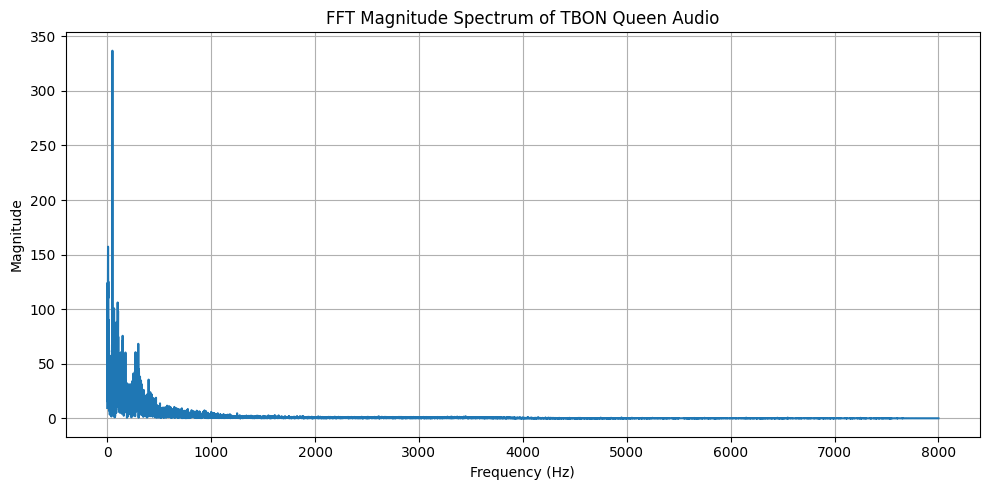

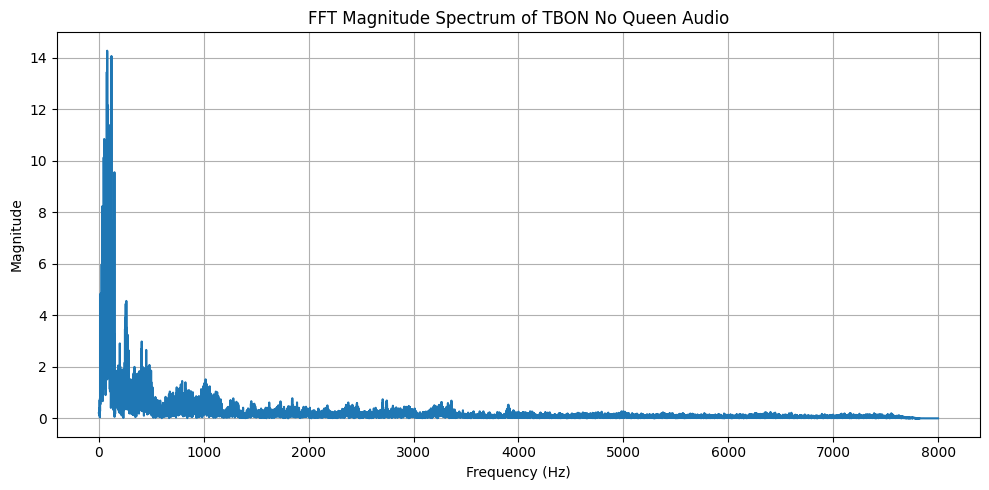

In [ ]:
# Function to Plot Comparative FFT
def plot_fft(y, sr, title):
    """
    Plots the FFT magnitude spectrum for the given audio signal.

    Parameters:
    - y: Audio signal
    - sr: Sampling rate
    - title: Title for the plot
    """
    fft_result = fft(y)
    freq = np.linspace(0, sr, len(fft_result))

    # Plot the FFT spectrum
    plt.figure(figsize=(10, 5))
    plt.plot(freq[:len(freq)//2], np.abs(fft_result)[:len(freq)//2])
    plt.title(title)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.grid()
    plt.tight_layout()
    plt.show()

# Plot FFT for Sample Audio Files
try:
    # Load example audio for Queen Audio
    y_queen, sr_queen = librosa.load('/content/drive/My Drive/BeeHive/Datasets/TBON_Processed_Organized/Queen/GH001 - Active - Day - 141022_0659_0751-187-0.wav', sr=16000)
    plot_fft(y_queen, sr_queen, 'FFT Magnitude Spectrum of TBON Queen Audio')

    # Load example audio for No Queen Audio
    y_noqueen, sr_noqueen = librosa.load('/content/drive/My Drive/BeeHive/Datasets/TBON_Processed_Organized/No_Queen/CJ001 - Missing Queen - Day -  (104)-99-7.wav', sr=16000)
    plot_fft(y_noqueen, sr_noqueen, 'FFT Magnitude Spectrum of TBON No Queen Audio')

except FileNotFoundError as e:
    print(f"File not found: {e}")
except Exception as e:
    print(f"An error occurred: {e}")

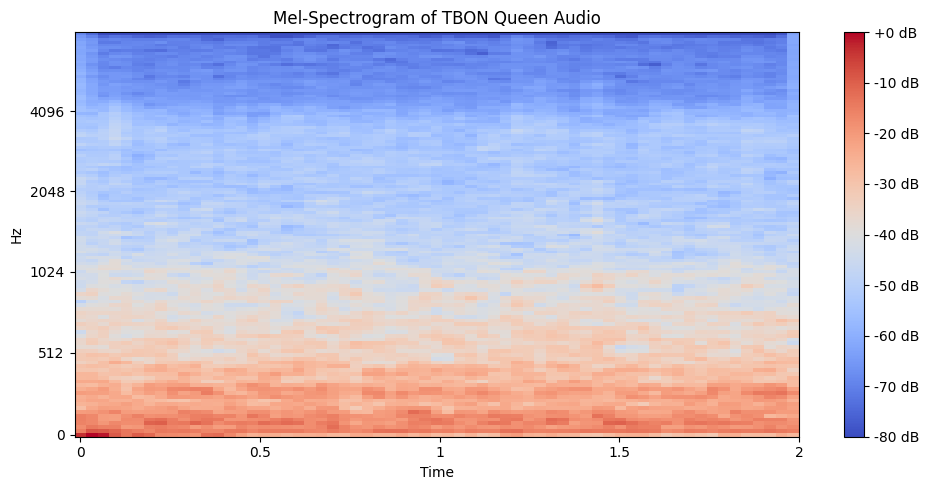

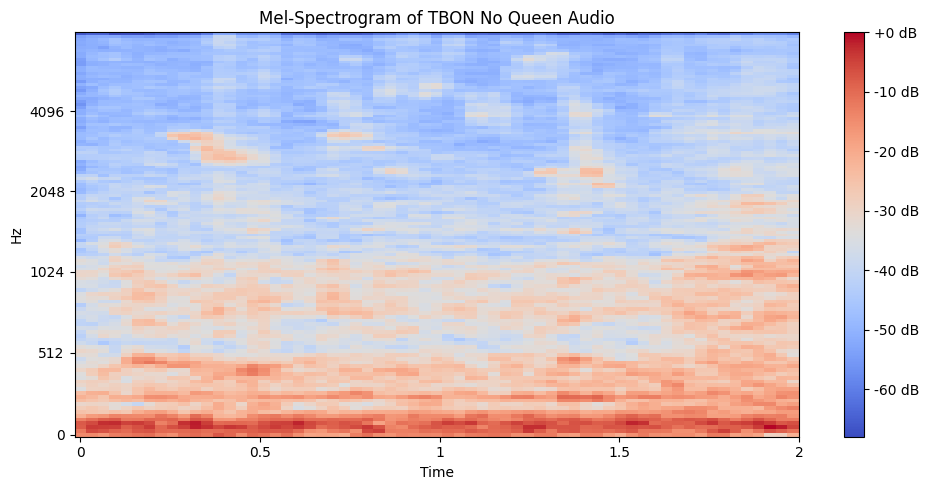

In [ ]:
# Function to Plot Spectrogram
def plot_spectrogram(y, sr, title):
    """
    Plots the Mel-Spectrogram for the given audio signal.

    Parameters:
    - y: Audio signal
    - sr: Sampling rate
    - title: Title for the plot
    """
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

    # Plot the Mel-Spectrogram
    plt.figure(figsize=(10, 5))
    librosa.display.specshow(mel_spec_db, sr=sr, x_axis='time', y_axis='mel', cmap='coolwarm')
    plt.title(title)
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()
    plt.show()

# Example Usage: Plot Spectrograms for TBON Queen and TBON No Queen Audio
try:
    # Queen Audio
    y_queen, sr_queen = librosa.load('/content/drive/My Drive/BeeHive/Datasets/TBON_Processed_Organized/Queen/GH001 - Active - Day - 141022_0659_0751-187-0.wav', sr=16000)
    plot_spectrogram(y_queen, sr_queen, 'Mel-Spectrogram of TBON Queen Audio')

    # No Queen Audio
    y_noqueen, sr_noqueen = librosa.load('/content/drive/My Drive/BeeHive/Datasets/TBON_Processed_Organized/No_Queen/CJ001 - Missing Queen - Day -  (104)-99-7.wav', sr=16000)
    plot_spectrogram(y_noqueen, sr_noqueen, 'Mel-Spectrogram of TBON No Queen Audio')

except FileNotFoundError as e:
    print(f"File not found: {e}")
except Exception as e:
    print(f"An error occurred: {e}")


Note:
I directly took the best hyperparameters from the other code I submitted and used it for the CNN Bi-LSTM model Architecture


In [ ]:
# Step 4: Model Architecture
def build_model():
    model = Sequential()

    # CNN Layers
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(13, 1, 1)))
    model.add(MaxPooling2D((2, 2), padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), padding='same'))
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), padding='same'))

    # Reshape for LSTM
    model.add(Flatten())
    model.add(Reshape((model.output_shape[1], 1)))

    # BI-LSTM Layers
    model.add(Bidirectional(LSTM(64, return_sequences=True)))
    model.add(Dropout(0.3))
    model.add(Bidirectional(LSTM(32, return_sequences=True)))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(128)))
    model.add(Dropout(0.5))

    # Dense Output Layer
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
# Step 5: Train the Model
X_train, X_test, y_train, y_test = train_test_split(X_tbon, y_tbon, test_size=0.2, random_state=42)

# Reshape the data
X_train = X_train.reshape((-1, 13, 1, 1))
X_test = X_test.reshape((-1, 13, 1, 1))

model = build_model()
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/100
715/715 ━━━━━━━━━━━━━━━━━━━━ 29s 27ms/step - accuracy: 0.9495 - loss: 0.1361 - val_accuracy: 1.0000 - val_loss: 2.7087e-04
Epoch 2/100
715/715 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.9992 - loss: 0.0040 - val_accuracy: 0.9990 - val_loss: 0.0045
Epoch 3/100
715/715 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - accuracy: 0.9981 - loss: 0.0096 - val_accuracy: 1.0000 - val_loss: 6.4059e-04
Epoch 4/100
715/715 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - accuracy: 0.9990 - loss: 0.0032 - val_accuracy: 1.0000 - val_loss: 4.8348e-05
Epoch 5/100
715/715 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.9996 - loss: 0.0013 - val_accuracy: 1.0000 - val_loss: 2.5444e-05
Epoch 6/100
715/715 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - accuracy: 0.9997 - loss: 3.8538e-04 - val_accuracy: 1.0000 - val_loss: 5.9600e-06
Epoch 7/100
715/715 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - accuracy: 0.9986 - loss: 0.0055 - val_accuracy: 1.0000 - val_loss: 3.8213e-04
Epoch 8/100
715/715 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step 

In [ ]:
# Evaluate model function
def evaluate_model(X, y, dataset_name):
    # Reshape the input data to match the model's expected input shape
    X_reshaped = X.reshape(X.shape[0], X.shape[1], 1, 1)  # Add extra dimensions
    # Make predictions
    y_pred = (model.predict(X_reshaped) > 0.5).astype(int)

    # Classification report
    print(f"Classification Report for {dataset_name}:")
    print(classification_report(y, y_pred, target_names=["No Queen", "Queen"]))

    # Confusion matrix
    cm = confusion_matrix(y, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Queen", "Queen"])
    disp.plot(cmap="coolwarm", values_format="d")
    plt.title(f"Confusion Matrix for {dataset_name}")
    plt.show()

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Classification Report for Hive 1:
              precision    recall  f1-score   support

    No Queen       0.41      0.23      0.30      1008
       Queen       0.46      0.67      0.55      1008

    accuracy                           0.45      2016
   macro avg       0.44      0.45      0.42      2016
weighted avg       0.44      0.45      0.42      2016



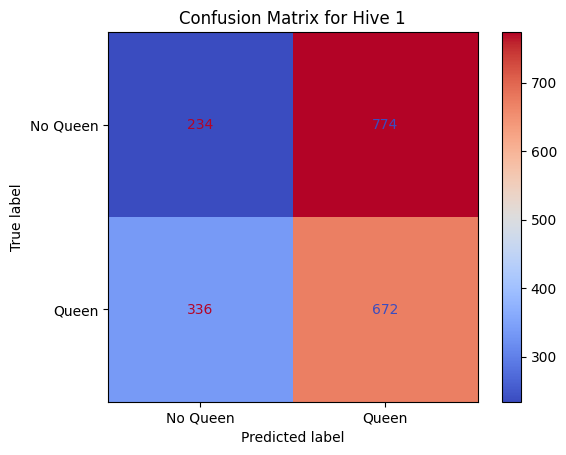

In [ ]:
# Evaluate on Hive 1
evaluate_model(X_hive1, y_hive1, "Hive 1")

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Classification Report for Hive 3:
              precision    recall  f1-score   support

    No Queen       0.29      0.11      0.16      1008
       Queen       0.45      0.73      0.56      1008

    accuracy                           0.42      2016
   macro avg       0.37      0.42      0.36      2016
weighted avg       0.37      0.42      0.36      2016



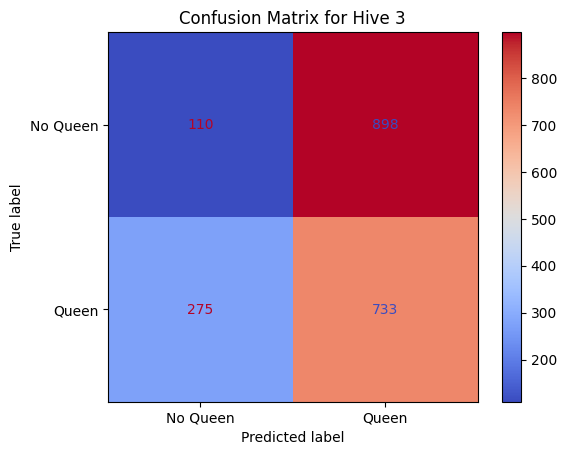

In [ ]:
# Evaluate on Hive 3
evaluate_model(X_hive3, y_hive3, "Hive 3")

126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Classification Report for Entire NuHive Dataset:
              precision    recall  f1-score   support

    No Queen       0.36      0.17      0.23      2016
       Queen       0.46      0.70      0.55      2016

    accuracy                           0.43      4032
   macro avg       0.41      0.43      0.39      4032
weighted avg       0.41      0.43      0.39      4032



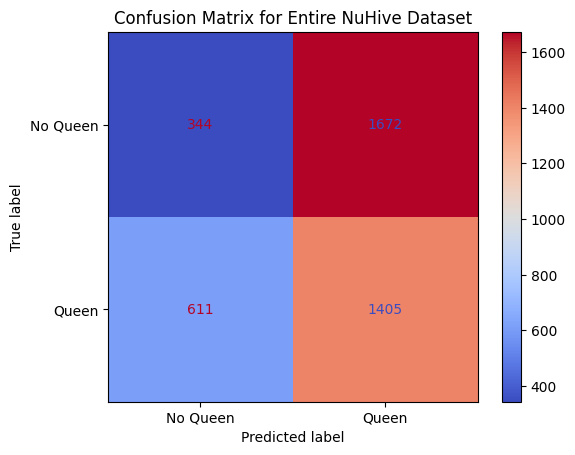

In [ ]:
# Evaluate on Entire NuHive Dataset
evaluate_model(X_nuhive_full, y_nuhive_full, "Entire NuHive Dataset")